In [8]:
import numpy as np
import pandas as pd

data = np.load('development_numpy/development.npy', allow_pickle=True)

metadata = pd.read_csv('metadata/development.csv')

feature_names_mapping = pd.read_csv('metadata/idx_to_feature_name.csv')

labels = metadata['word'].values  
speaker_ids = metadata['speaker_id'].values

snippet_ids = np.arange(len(metadata))

print('Data shape:', data.shape)
print('Labels shape:', labels.shape)


Data shape: (45296, 175, 44)
Labels shape: (45296,)


In [9]:
from sklearn.model_selection import train_test_split

subsample_fraction = 0.2
X_subsample, _, y_subsample, _, snippet_ids_subsample, _ = train_test_split(
    data, labels, snippet_ids, train_size=subsample_fraction, random_state=42)

print('Subsampled data shape:', X_subsample.shape)
print('Subsampled labels shape:', y_subsample.shape)

n_samples, n_features, n_time = X_subsample.shape
X_subsample_flat = X_subsample.reshape(n_samples, n_features * n_time)

print('Reshaped subsampled data shape:', X_subsample_flat.shape)


Subsampled data shape: (9059, 175, 44)
Subsampled labels shape: (9059,)
Reshaped subsampled data shape: (9059, 7700)


In [10]:
X_train_val, X_test, y_train_val, y_test, snippet_ids_train_val, snippet_ids_test = train_test_split(
    X_subsample_flat, y_subsample, snippet_ids_subsample, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val, snippet_ids_train, snippet_ids_val = train_test_split(
    X_train_val, y_train_val, snippet_ids_train_val, test_size=0.5, random_state=42)

print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)


Training data shape: (3170, 7700)
Training labels shape: (3170,)
Validation data shape: (3171, 7700)
Validation labels shape: (3171,)
Test data shape: (2718, 7700)
Test labels shape: (2718,)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print('Training data mean (scaled):', np.mean(X_train_scaled))
print('Training data std (scaled):', np.std(X_train_scaled))


Training data mean (scaled): 1.3658349445640501e-17
Training data std (scaled): 1.0000000000000013


In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print('Best hyperparameters (SVM):', grid_search.best_params_)
print('Best cross-validation score (SVM):', grid_search.best_score_)

best_svm = grid_search.best_estimator_
val_score_svm = best_svm.score(X_val_scaled, y_val)
test_score_svm = best_svm.score(X_test_scaled, y_test)
print('Validation accuracy (SVM):', val_score_svm)
print('Test accuracy (SVM):', test_score_svm)




Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  48.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  49.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  49.6s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  49.6s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.2min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.2min
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time= 1.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  41.9s
[CV] END ...................C=0.1, gamma=auto, k

Best hyperparameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


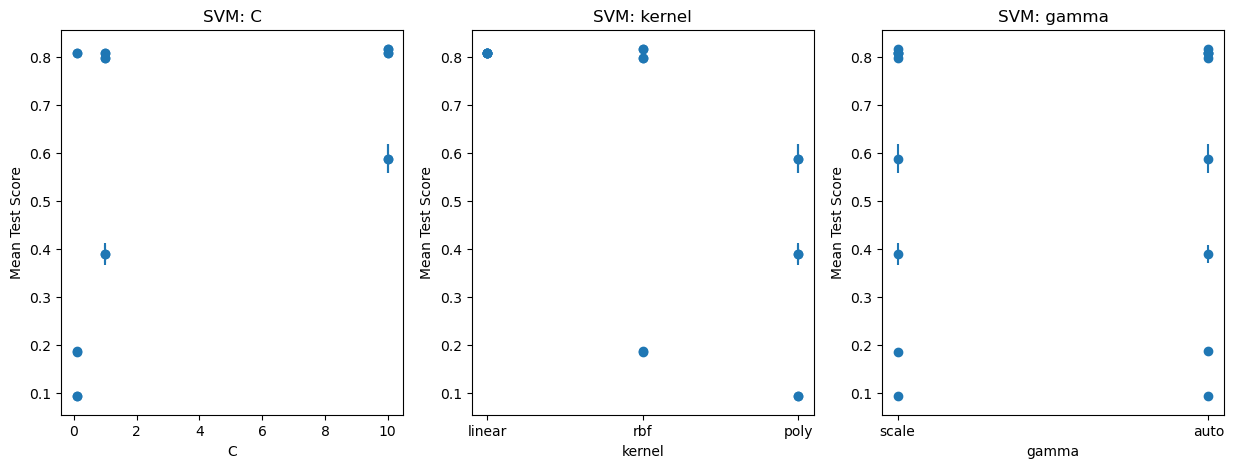

In [13]:
import matplotlib.pyplot as plt

def plot_grid_search(cv_results, param_grid, param_names, model_name):
    scores_mean = cv_results['mean_test_score']
    scores_std = cv_results['std_test_score']
    params = cv_results['params']

    fig, ax = plt.subplots(1, len(param_names), figsize=(15, 5))
    
    for i, param_name in enumerate(param_names):
        param_values = [param[param_name] for param in params]
        ax[i].errorbar(param_values, scores_mean, yerr=scores_std, fmt='o')
        ax[i].set_title(f'{model_name}: {param_name}')
        ax[i].set_xlabel(param_name)
        ax[i].set_ylabel('Mean Test Score')

    plt.show()

print(f"Best hyperparameters for SVM: {grid_search.best_params_}")

plot_grid_search(grid_search.cv_results_, param_grid, list(param_grid.keys()), 'SVM')